In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

mat_content = sio.loadmat( 'face(1).mat' )

face_data        = mat_content[ 'X' ]
face_data_labels = mat_content[ 'l' ]

print( 'Face Data {}'.format( face_data.shape ) )
print( 'Face Label {}'.format( face_data_labels.shape ) )

Face Data (2576, 520)
Face Label (1, 520)


In [55]:
train_set, test_set, train_label, test_label = train_test_split( face_data.T, face_data_labels.T, test_size = 0.2,
                                                                random_state = 10 )

train_set   = train_set.T.astype('float64')
test_set    = test_set.T.astype('float64')
train_label = train_label.T 
test_label  = test_label.T

print( 'Train_Set {}'.format( train_set.shape ) )
print( 'Test_Set {}'.format( test_set.shape ) )

print( 'Train_Label {}'.format( train_label.shape ) )
print( 'Test_Label {}'.format( test_label.shape ) )

Train_Set (2576, 416)
Test_Set (2576, 104)
Train_Label (1, 416)
Test_Label (1, 104)


# PCA

(2576,)


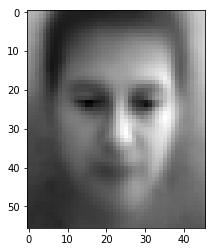

In [56]:
#Calculation of the mean face
mean_face = np.mean( train_set, axis = 1) 
print(mean_face.shape)
mean_face_img = np.reshape(mean_face,(46,56))
plt.imshow( mean_face_img.T, cmap = 'gist_gray')

In [57]:
phi_mat = train_set

for i in range( phi_mat.shape[ 1 ] ):
    phi_mat.T[ i ] = phi_mat.T[ i ] - mean_face
    
print( 'Phi_Mat Shape {}'.format( phi_mat.shape ) )

Phi_Mat Shape (2576, 416)


In [58]:
A = phi_mat

S = 1 / A.shape[ 1 ] * np.dot( A, A.T )
print( 'Covariance Matrix Shape {}'.format( S.shape ) )

Covariance Matrix Shape (2576, 2576)


In [59]:
hd_eig_vals, hd_eig_vecs = np.linalg.eig( S )

In [60]:
hd_eig_pairs = [ ( np.abs( hd_eig_vals[ i ] ), hd_eig_vecs[ :, i ] ) for i in range( len( hd_eig_vals ) ) ]
hd_eig_pairs.sort( key = lambda x: x[ 0 ], reverse = True )

for i in range( 10 ):
    print( hd_eig_pairs[ i ][ 0 ] )

961436.0948658308
541043.8664492436
450280.8926556715
266903.25965380203
214638.94630162368
144584.82244145861
122214.65612966754
109994.12194060766
94342.33167209689
81630.01887945815


In [61]:
M = 150

M_eig_vecs = []

for i in range( M ):
    M_eig_vecs.append( hd_eig_pairs[ i ][ 1 ] )
    
print( 'M Largest Eigen Pairs: {}'.format( len( M_eig_vecs ) ) )

M Largest Eigen Pairs: 150


In [62]:
M_eig_vecs = np.asarray( M_eig_vecs )

M_eig_vecs.shape

(150, 2576)

# Project Data

In [63]:
train_set_projected = np.dot( M_eig_vecs, train_set )

train_set_projected = train_set_projected.real
train_set_projected.shape

(150, 416)

# LDA

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = train_set_projected.T
Y = train_label.reshape( train_label.shape[ 1 ] )

classifier = LinearDiscriminantAnalysis( n_components = 30 )
classifier.fit( X, Y )

LinearDiscriminantAnalysis(n_components=30, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [65]:
X_test = np.dot( M_eig_vecs, test_set ).T

Y_test_predicted = classifier.predict( X_test )
Y_test = test_label

In [66]:
Accuracy = np.sum( Y_test_predicted == Y_test )

print( 'Accuracy: {}'.format( Accuracy ))

Accuracy: 84


# Ensemble

## Bagging

In [74]:
from sklearn.ensemble import BaggingClassifier

M_pca = 150
M_lda = 30

print( 'M_pca: {} , M_lda: {} \n '.format( M_pca, M_lda) )

Num_machines = 50

## PCA ##
# Keeping the subspace constant, Lets perform PCA first
print( '\n### PCA Information ### \n')
bagging_mean_face = np.mean( train_set, axis = 1) 

bagging_phi_mat = train_set

for i in range( phi_mat.shape[ 1 ] ):
    bagging_phi_mat.T[ i ] = bagging_phi_mat.T[ i ] - bagging_mean_face
    
print( 'Phi_Mat Shape {}'.format( bagging_phi_mat.shape ) )

bagging_A = bagging_phi_mat

bagging_S = 1 / bagging_A.shape[ 1 ] * np.dot( bagging_A.T, bagging_A ) # Perform in low dimension to save computation
print( 'Covariance Matrix Shape {}'.format( bagging_S.shape ) )

bagging_ld_eig_vals, bagging_ld_eig_vecs = np.linalg.eig( bagging_S )

bagging_ld_eig_pairs = [ ( np.abs( bagging_ld_eig_vals[ i ] ), bagging_ld_eig_vecs[ :, i ] ) for i in range( len( bagging_ld_eig_vals ) ) ]
bagging_ld_eig_pairs.sort( key = lambda x: x[ 0 ], reverse = True )

bagging_M_eig_vecs = []

# Convert LD to HD Eigenvectors and select M largest
for i in range( M_pca ):
    bagging_M_eig_vecs.append( np.dot( bagging_A, bagging_ld_eig_pairs[ i ][ 1 ] ) )
    
print( 'M Largest Eigen Pairs: {}, of Size: {}'.format( len( bagging_M_eig_vecs ), bagging_M_eig_vecs[ 0 ].shape ) )

pca_subspace = np.asarray( bagging_M_eig_vecs )

print( 'PCA subspace: {}'.format( pca_subspace.shape ) )

## Project Training Data Onto M_pca Subspace ##
bagging_train_set   = np.dot( pca_subspace, train_set ).T
bagging_test_set    = np.dot( pca_subspace, test_set ).T

bagging_train_label = train_label.reshape( train_label.shape[ 1 ] ) 
bagging_test_label  = test_label.reshape( test_label.shape[ 1 ] )


## LDA Classifier ##
print( '\n### LDA Information ### \n')
pca_lda_clf = LinearDiscriminantAnalysis( n_components = M_lda )

## Bagging ##
model = BaggingClassifier( base_estimator = pca_lda_clf, n_estimators = Num_machines )
model.fit( bagging_train_set, bagging_train_label )

## Predict ##
bagging_test_predicted = model.predict( bagging_test_set )

Accuracy = np.sum( bagging_test_predicted == bagging_test_label )
print( 'Accuracy: {}%'.format( Accuracy ))

M_pca: 150 , M_lda: 30 
 

### PCA Information ### 

Phi_Mat Shape (2576, 416)
Covariance Matrix Shape (416, 416)
M Largest Eigen Pairs: 150, of Size: (2576,)
PCA subspace: (150, 2576)

### LDA Information ### 



/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/aufar/anaconda3/lib/python3.7/site-packages/sk

Accuracy: 82%


/home/aufar/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [68]:
bagging_train_set.shape

(416, 100)